# Supplemental Figure 11 — Comparative analysis of mutational spectra and coverage between DP6 mutagenesis and retron-encoded DMS libraries.


This notebook reproduces **Figure S11** from the supplemental manuscript.

---

### Figure Summary

<div style="text-indent:-2em; padding-left:2em"><strong>(A)</strong> Pomparison of mutation rates per position between mutagenesis plasmid and DMS library in AsLOV2 (Illumina)</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(B)</strong> Dot plot of plasmid library coverage of encoded retron edits against the observed phage retron mutation rates in the DMS library (Illumina) </div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(C)</strong> Per nucleobase coverage of edits when using the mutagenesis plasmid (Illumina)</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(D)</strong> Relative frequency of single, double, and triple mutations using the DMS library, comparing the expected mutagenesis rates if editing was equal in efficiency between each group versus what edits were observed in each group (Illumina)</div>  
<div style="text-indent:-2em; padding-left:2em"><strong>(E)</strong> Overview of the proportion of encoded codon mutations in the DMS library versus the reference codons across AsLOV2</div>  

## Notebook Setup
----------------------------

Run the following cell to import all required libraries, define plotting settings, and configure the environment for data analysis and visualization.

In [ ]:
# --- Import necessary modules ---
import os
import sys
os.chdir("..")
import json
import pickle as pkl
from importlib import reload
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats
import scipy
from Bio import SeqIO
import csv
from collections import Counter
from Bio.SeqIO import QualityIO
from utils import dna_rev_comp, translate_dna2aa
from scripts.preprocessing_functions import *
from scripts.plotting import *
import matplotlib.colorbar as mcolorbar 
from scripts.Nanopore_functions import *
from scripts.Illumina_functions import *
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# ======================== PLOTTING SETTINGS ========================

# --- Custom color map for mutation visualization ---
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
], N=256)

# --- Seaborn theme configuration ---
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.linewidth": 1
}
sns.set_theme(context="paper", style='ticks', palette="Greys_r", rc=custom_params)

# --- General matplotlib settings ---
fs = 8  # font size
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    'font.family': 'Avenir Next',
    'font.weight': 'demi', 
    'font.size': fs,
    'text.color': '#231F20',
    'axes.labelcolor': '#231F20',
    'xtick.color': '#231F20',
    'ytick.color': '#231F20',
    'axes.edgecolor': '#231F20',
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'pdf.fonttype': 42,
    'text.usetex': False
})
sns.set_context("paper", rc={
    "font.size": fs,
    "axes.titlesize": fs + 1,
    "axes.labelsize": fs,
    "axes.linewidth": 1,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "legend.title_fontsize": fs + 1
})

# ======================== LAYOUT PARAMETERS ========================

# --- Pre-defined figure dimensions for multi-panel plots ---
hi = 10.5 * 0.75
wi3 = 2.24
wi2 = 4.76
wi1 = 7.24
nr = 5

# --- Utility for shortening sample names ---
short_fn = np.vectorize(lambda x: x[:5])

## Figure S11A: Comparison of mutation rates per position between mutagenesis plasmid and DMS library in AsLOV2 (Illumina)
----------------------------

Mutation rates per amino acid position. Total amino acid mutation rates per site were calculated as the sum of all normalized mutation frequencies. The DMS library exhibited higher median (mean) per-position mutation rates [0.00369 (0.00377)] compared to DP6 [0.00115 (0.00134)], reflecting increased editing density. Positions with sequencing depth below 2000 reads were excluded. 

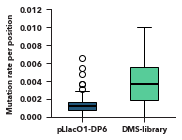

In [15]:
# ====================== LOAD INDEL AND MUTATION DATA ======================

# --- Load indel frequency data (DNA-level, unfiltered ROI) ---
DP6_indels = pd.read_csv(
    "final_output/DP6/combined/enrichments/DNA/DP6_BC1_S1_combined_roiFalse_DNA_indel_freq.csv",
    index_col=0
)
RL8_indels = pd.read_csv(
    "final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_indel_freq.csv",
    index_col=0
)

# --- Load AA-level enrichment data (ROI-filtered) ---
RL8_mutations = pd.read_csv(
    "final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv",
    index_col=0
)
DP6_mutations = pd.read_csv(
    "final_output/DP6/combined/enrichments/AA/DP6_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv",
    index_col=0
)

# --- Drop positions with missing data from indel matrices ---
DP6_indels.dropna(axis=1, how="any", inplace=True)
RL8_indels.dropna(axis=1, how="any", inplace=True)

# ====================== SLICE INDEL TYPES AND SUM MUTATION FREQUENCIES ======================

# --- Extract insertion and deletion rows separately ---
DP6_insertions = DP6_indels.loc["insertion", :]
RL8_insertions = RL8_indels.loc["insertion", :]
DP6_deletions = DP6_indels.loc["deletion", :]
RL8_deletions = RL8_indels.loc["deletion", :]

# --- Compute total mutation frequencies (sum across positions) ---
DP6_muts = DP6_mutations.sum()
RL8_muts = RL8_mutations.sum()

# ====================== DEFINE COLOR SCHEME FOR PLOTTING ======================

color_DP6 = "#22577A"     # dark blue for DP6
color_RL8 = "#57CC99"     # medium green for RL8
median_color = "black"    # black for medians or reference

# ====================== MUTATION RATE PER POSITION ======================

plt.figure(figsize=(wi3, hi / 4))

# --- Plot boxplots of per-position mutation rates for DP6 and RL8 ---
bp = plt.boxplot(
    [DP6_muts, RL8_muts],                # y-values for each group
    tick_labels=["pLlacO1-DP6", "DMS-library"],  # x-axis labels
    showfliers=True,                     # show outliers
    patch_artist=True,                   # allows coloring boxes
    widths=0.45,
    positions=[1, 2]                     # manually position boxes for spacing
)

# --- Label y-axis ---
plt.ylabel("Mutation rate per position")

# --- Set y-axis range ---
plt.ylim(0.000, 0.012) 

# --- Apply custom colors to boxplots ---
for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)

# --- Customize median lines ---
for median in bp['medians']:
    median.set(color=median_color, linewidth=2)

# --- Save plot to file ---
# plt.savefig('final_output/DP6_vs_RL8_mutationrate_per_pos_boxplot.pdf', bbox_inches='tight')

# --- Display the plot inline ---
plt.show()

## Figure S11B: Dot plot of plasmid library coverage of encoded retron edits against the observed phage retron mutation rates in the DMS library (Illumina)
----------------------------
Positional bias between retron DMS library plasmid encoded and phage observed mutations. DMS-encoded substitutions were compared to their observed frequencies in phage populations. A strong correlation was observed (Spearman ρ = 0.77), indicating that enrichment patterns are largely dictated by library design.

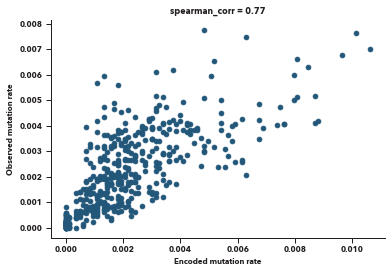

In [16]:
# ====================== LOAD RL8 DATA AND DEFINE REFERENCE SEQUENCES ======================

RL8_mutations = pd.read_csv("final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
RL8_DNA_mutations = pd.read_csv("final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_enrichment_relative.csv", index_col=0)
RL8_encoded_muts = pd.read_csv("final_output/P0111_RetronLib/BC3_R1/blastpipeline/enrichments/BC3_RL_encoded_mutations.csv", index_col=0).T


RL8_observed_ref = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
## see /home/student/anna/DMS_analysis/data/fastq/P02_RL8_LOV2/references/RL8_BC1_S1_Nt_filt_ref.fasta

RL8_encoded_ref = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC"
cut_left = RL8_encoded_ref.index("CGCCGCATGGAAGCGATTAA")
cut_right = RL8_encoded_ref.index("TGGATAACCGCGTG") + len("TGGATAACCGCGTG")

# ====================== PROCESS RL8 DNA MUTATION DATA ======================

# --- Identify columns (positions) that contain only NaN values ---
# These positions likely have very low sequencing coverage and no reliable data
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]

# --- Calculate the total relative mutation rate at each position ---
RL8_DNA_muts_prop = RL8_DNA_mutations.sum()

# --- Identify and mask the position with the highest mutation rate ---
# This is likely a silent mutation (e.g. a technical artifact or contamination)
mask_max = RL8_DNA_muts_prop.idxmax()
RL8_DNA_muts_prop[mask_max] = np.nan

# --- Normalize mutation proportions across all valid positions ---
RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()

# --- Sum total mutation counts per position (raw, unnormalized) ---
RL8_DNA_mutations_sum = RL8_DNA_mutations.sum()  

# --- Mask problematic positions again (masking is lost after `.sum()` operation) ---
RL8_DNA_mutations_sum[mask_max] = np.nan
RL8_DNA_mutations_sum[empty_cols] = np.nan
RL8_DNA_muts_prop[mask_max] = np.nan
RL8_DNA_muts_prop[empty_cols] = np.nan

# ====================== PROCESS RL8 ENCODED MUTATIONS ======================


# --- Cut the encoded mutation matrix to match the observed reference frame ---
# Keep only the region between cut_left and cut_right (matching the actual DNA window)
RL8_encoded_muts = RL8_encoded_muts.iloc[:,cut_left:cut_right]

# --- Mask positions with low coverage (same as in the observed DNA mutations) ---
# Identify positions (columns) in the observed data that have only NaN values
empty_cols = RL8_DNA_mutations.columns[RL8_DNA_mutations.isna().all()]
empty_cols = [int(empty_col) for empty_col in empty_cols]

# --- Extract encoded mutation proportions from the first row ---
RL8_encoded_muts_prop = RL8_encoded_muts.iloc[0,:].values

# --- Replace low-coverage positions and the masked maximum with NaN ---
RL8_encoded_muts_prop = pd.DataFrame([RL8_encoded_muts_prop[i] if i not in empty_cols+ [int(mask_max)] else np.nan for i in range(len(RL8_encoded_muts_prop))])


# --- Normalize the encoded mutation profile so that the sum is 1 ---
RL8_encoded_muts_prop = (RL8_encoded_muts_prop/RL8_encoded_muts_prop.sum()).values.flatten()

# ====================== CORRELATION: ENCODED VS OBSERVED MUTATION RATES ======================

# --- Remove missing values (NaNs) from both mutation profiles ---
RL8_DNA_muts_prop = RL8_DNA_muts_prop.dropna()
RL8_encoded_muts_prop = pd.DataFrame(RL8_encoded_muts_prop).dropna()

plt.scatter(RL8_encoded_muts_prop, RL8_DNA_muts_prop, color = "#22577A")

plt.title(f"spearman_corr = {round(scipy.stats.spearmanr(RL8_encoded_muts_prop, RL8_DNA_muts_prop)[0],2)}")
plt.xlabel("Encoded mutation rate")
plt.ylabel("Observed mutation rate")

plt.show()
# plt.savefig("final_output/RL8/RL8_encoded_vs_observed_correlation.pdf", bbox_inches='tight')
# plt.savefig("final_output/RL8/RL8_encoded_vs_observed_correlation.png", bbox_inches='tight')

## Figure S11C:  Per nucleobase coverage of edits when using the mutagenesis plasmid (Illumina)
----------------------------
Nucleotide-level mutational spectrum of plLacO1-DP6. Mutations induced by plLacO1-DP6 were biased toward G:C → A:T transitions, and all percentages were consistent with known MP6-derived activity. Analysis included all sequenced positions with ≥2000 read depth.

This figure was generated using the script `1_Illumina_analyze_mutation_enrichment.py`, which performs the mutation enrichment analysis based on Illumina sequencing data.


![Alt Text](/Volumes/ag-niopek/Niopek_Lab/8_Data/1_Nanopore/DMS_analysis/figure_notebooks/figure_illustrations/Figure_S11C.png)

## Figure S11D:  Relative frequency of single, double, and triple mutations using the DMS library, comparing the expected mutagenesis rates if editing was equal in efficiency between each group versus what edits were observed in each group (Illumina)
----------------------------

Codon-level complexity of induced edits in DMS-edited phages. For the targeted AsLOV2 sequence, all observed codon changes were classified as single-, double-, or triple-nucleotide substitutions, and their respective proportions were calculated across the entire DMS-edited phage population. Expected proportions were similarly determined by categorizing every encoded substitution in the library—across all target positions—into the same three classes but assumed to be of equal likelihood. The comparison reveals that the DMS library is biased toward inducing single-nucleotide codon substitutions relative to more complex edits. 

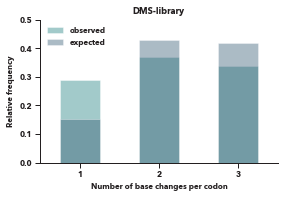

In [17]:
# --- Preferred E. coli codons used for encoding each amino acid in the RL8 retron library ---

ecoli_pref = {
            "A": 'GCG',
            "R": 'CGT',
            "N": 'AAC',
            "D": 'GAT',
            "C": 'TGC',
            "Q": 'CAG',
            "E": 'GAA',
            "G": 'GGC',
            "H": 'CAT',
            "I": 'ATT',
            "L": "CTG",
            "K": 'AAA',
            "M": 'ATG',
            "F": "TTT",
            "P": 'CCG',
            "S": 'AGC',
            "T": 'ACC',
            "W": 'TGG',
            "Y": "TAT",
            "V": 'GTG',
}

# ====================== LOAD CODON ENRICHMENT COUNTS FOR VARIANT ======================

variant = "RL8"
Folder = f"final_output/{variant}/combined/" 

# --- Load codon enrichment count matrix (per position) ---
# Each column = position; each row = codon
enrichment_counts = pd.read_csv(f"{Folder}/enrichments/Codons/{variant}_BC1_S1_combined_roiTrue_Codons_enrichment_counts.csv", index_col = 0)
FigFolder = Folder+ "/plots/Codons/"


amplicon_AraCLOV2 = 'CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG'
start_LOV2  = "ttagccacaa".upper()
end_LOV2 = "cggccaaa".upper()

LOV2_gene = amplicon_AraCLOV2[amplicon_AraCLOV2.index(start_LOV2):amplicon_AraCLOV2.index(end_LOV2)+len(end_LOV2)]

enrichment_counts_sum = enrichment_counts.sum()

# --- Identify and mask the most enriched position (likely contamination or outlier) ---
mask_max = np.where(enrichment_counts_sum == enrichment_counts_sum.max())[0][0]

enrichment_counts.iloc[:,mask_max] = 0
# ====================== COUNT SINGLE, DOUBLE, TRIPLE NUCLEOTIDE CHANGES (CODON-WISE) ======================

# --- Split the LOV2 region into reference codons (non-overlapping triplets) ---
ref_codons = [LOV2_gene[i:i+3] for i in range(0, len(LOV2_gene), 3)]

# --- Initialize dictionary to track number of mutations by type ---
# Keys: 1, 2, or 3 nucleotide changes within a codon
Nt_changes = {1:0, 2:0, 3:0}


for pos, ref_codon in enumerate(ref_codons):
    mut_Codons = enrichment_counts.iloc[:,pos]
    for mut_codon in mut_Codons.index:
        if mut_codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_codon[i] for i in range(3)])
            Nt_changes[n_changes] += mut_Codons[mut_codon]

# --- Normalize to obtain relative proportions of single, double, and triple mutations ---
relative_Nt_changes_observed = {key: val/sum(Nt_changes.values()) for key,val in Nt_changes.items()}

# ====================== CALCULATE EXPECTED SINGLE/DOUBLE/TRIPLE NT CHANGES (CODON-WISE) ======================

# --- Initialize dictionary to count expected codon changes by number of nucleotide substitutions ---
# This assumes all possible E. coli-preferred codon substitutions are equally likely
expected_Nt_changes = {1:0, 2:0, 3:0}

for ref_codon in ref_codons: 
    for mut_Codon in ecoli_pref.values(): 
        if mut_Codon != ref_codon: 
            n_changes = sum([ref_codon[i] != mut_Codon[i] for i in range(3)])
            expected_Nt_changes[n_changes] += 1

# --- Normalize to obtain relative expected frequencies of 1-, 2-, and 3-nt changes ---
relative_expected_Nt_changes = {key: val/sum(expected_Nt_changes.values()) for key, val in expected_Nt_changes.items()}

# ====================== PLOT OBSERVED VS EXPECTED CODON MUTATION TYPES ======================

fig = plt.figure(figsize=(wi*0.6, hi/3))

sns.barplot(relative_Nt_changes_observed, alpha = 0.5, label = "observed", color = "#38A3A5", width = 0.5)
sns.barplot(relative_expected_Nt_changes, alpha = 0.4, label = "expected", color = "#22577A", width = 0.5)
plt.legend(frameon = False)
plt.xlabel("Number of base changes per codon")
plt.ylabel("Relative frequency")
plt.title("DMS-library")
plt.ylim(top = 0.50)
# plt.savefig(f"{FigFolder}/{variant}_base_changes_per_codon_exp_vs_obs.pdf")
plt.show()
        

## Figure S11E:  Overview of the proportion of encoded codon mutations in the DMS library versus the reference codons across AsLOV2
----------------------------

Codon substitution spectrum in the DMS-edited phage population. Heatmap shows the relative frequency of all observed codon substitutions in the AsLOV2 region. Columns indicate codons encoded in the DMS library (“Retron Encoded Codons”) or absent, while rows represent all possible codon identities sorted alphabetically. Right-side annotations show the number of times each codon occurs in the AsLOV2 reference sequence (excluding positions with <2000 reads). Mutational frequencies were normalized per position. Position 446 (G→A) was masked from this analysis due to its high background mutation rate (~95%), which is presumed to be an early off-target propagation event rather than a library-encoded change.


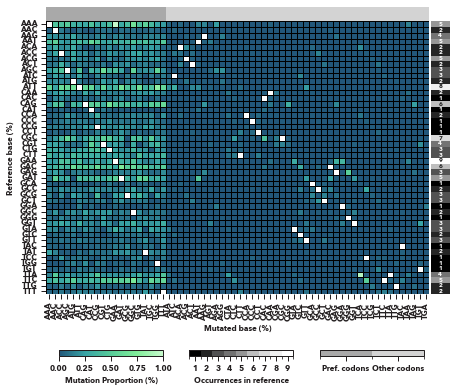

In [18]:
# --- Get enrichment data ---

Folder = "final_output/RL8/combined/enrichments/Codons/" 

enrichment = pd.read_csv(f"{Folder}/RL8_BC1_S1_combined_roiTrue_Codons_enrichment_relative.csv", index_col = 0)
# --- Identify columns in the enrichment matrix that contain only NaN values ---
empty_cols = enrichment.columns[enrichment.isna().all()]

# --- Detect the column (position) with the highest total enrichment ---
max_col = enrichment.sum().idxmax()
# --- Mask the most enriched column (likely a silent mutation fixed in all phages) ---
enrichment[max_col] = np.nan 

# --- Replace all remaining NaN values with 0 for downstream calculations ---
enrichment.fillna(0, inplace=True)

# --- Set reference sequence for spectrum analysis (codon-level) ---
ref = LOV2_gene

# --- Calculate mutational spectrum from enrichment data ---
#     - Returns: absolute and percentage frequencies of codon mutations
mut_spectrum_codons,mut_spectrum_codons_perc = calc_mut_spectrum_from_enrichment(enrichment, ref_seq=ref, data_type="Codons")

# ======================== FILTERING AND FORMATTING MUTAGENIC SPECTRUM ========================

# --- Compute nucleotide-based reference length (3 nt per codon) ---
ref_len = len(enrichment.columns) * 3 ## Nts instead of codons

# --- Adjust length to include 5′ region (AraC before LOV2 start) ---
ref_len = ref_len + amplicon_AraCLOV2.index(start_LOV2) 

# --- Generate codon-level reference sequence from AraC-LOV2 amplicon ---
ref_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0,ref_len, 3)]

# --- Remove codons at positions with low coverage (i.e., excluded from enrichment) ---
ref_codons = [codon for idx, codon in enumerate(ref_codons) if str(idx) not in empty_cols]

# --- Retrieve sorted list of E. coli preferred codons ---
pref_codons = sorted(ecoli_pref.values())

# --- Reorder mutagenic spectrum: preferred codons first, then others ---
mut_spec_perc_ordered = pd.concat((mut_spectrum_codons_perc.loc[:,pref_codons], mut_spectrum_codons_perc.loc[:,[codon for codon in codons if codon not in pref_codons]]),axis = 1)
# --- Filter rows to only include codons found in reference ---
mut_spec_perc_ordered = mut_spec_perc_ordered.loc[[codon for codon in codons if codon in ref_codons],:] 
# --- Sort codon rows alphabetically ---
mut_spec_perc_ordered = mut_spec_perc_ordered.reindex(sorted(mut_spec_perc_ordered.index), axis=0) 


# ======================== ANNOTATION OF A ARAC-SPECIFIC CODONS ========================

# --- Find index where LOV2 begins in AraC-LOV2 reference sequence ---
LOVstart = amplicon_AraCLOV2.index(start_LOV2)
# --- Get AraC-only codons (upstream of LOV2) ---
AraC_codons = [amplicon_AraCLOV2[i:i+3] for i in range(0, LOVstart, 3)]
# --- Get LOV2 codons (targeted region) ---
LOV_codons = [amplicon_AraCLOV2[i:i+3] for i in range(LOVstart, ref_len, 3)]
# --- Identify codons unique to AraC (not found in LOV2 region) ---
AraC_spec_codons = [codon for codon in AraC_codons if codon not in LOV_codons]

# --- Count codon occurrences in the LOV2 region for row annotation ---
counter_LOV = Counter(LOV_codons)
# --- Ensure all codons in mutational spectrum are represented in the counter ---
for codon in mut_spec_perc_ordered.index:
    if codon not in counter_LOV:
        counter_LOV[codon] = 0
   
# --- Sort codon counter alphabetically by codon ---
counter_LOV = dict(sorted(counter_LOV.items()))

# --- Generate column annotations: 0 = preferred codon, 1 = non-preferred ---
col_annot = [0 if codon in pref_codons else 1 for codon in mut_spec_perc_ordered.columns]
# --- Get row annotation values from codon usage in LOV2 ---
row_annots = list(counter_LOV.values())


# --- Convert row annotation values into colormap colors (for plotting) ---
row_cmap = plt.get_cmap('Greys').reversed()
colors = ["darkgrey", "lightgrey"]
col_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)

norm = plt.Normalize(min(row_annots), max(row_annots))
row_annot = [row_cmap(norm(value)) for value in row_annots]

row_annot_df = pd.DataFrame(row_annots, index=mut_spec_perc_ordered.index) 
col_annot_df = pd.DataFrame(col_annot).T

# ======================== PLOTTING MUTAGENIC SPECTRUM WITH ANNOTATIONS ========================

fig, axes = plt.subplots(4, 2, figsize=(wi1, hi*0.7), 
                         gridspec_kw={"height_ratios": [0.05, 1, 0.02, 0.02], "width_ratios": [1, 0.05]})

plt.subplots_adjust(hspace=0.01, wspace=0.01)

# --- Top row: Column annotation heatmap (preferred vs non-preferred codons) ---
sns.heatmap(col_annot_df, cmap=col_cmap, cbar=False, ax=axes[0, 0], xticklabels=False, yticklabels=False)
axes[0, 1].axis("off")

# --- Center: Main mutagenic spectrum heatmap (percentage mutation rates) ---
sns.heatmap(mut_spec_perc_ordered, cmap=custom_cmap, cbar=False, ax=axes[1, 0], xticklabels=True, yticklabels=True, linecolor="black", linewidths=0.5)
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=90)
axes[1, 0].set_yticklabels(axes[1, 0].get_yticklabels(), rotation=0)
axes[1, 0].set_xlabel('Mutated base (%)')
axes[1, 0].set_ylabel('Reference base (%)')

# --- Right: Row annotation heatmap (codon occurrences in LOV2 region) ---
sns.heatmap(row_annot_df, cmap=row_cmap, cbar=False, ax=axes[1, 1], xticklabels=False, yticklabels=False, annot=True, annot_kws={"size": 6})


# --- Define manual positions for horizontal colorbars below the heatmaps ---
cbar_ax1 = fig.add_axes([0.15, 0.0, 0.2, 0.015])  # Main heatmap
cbar_ax2 = fig.add_axes([0.4, 0.0, 0.2, 0.015])   # Row annotation
cbar_ax3 = fig.add_axes([0.65, 0.0, 0.2, 0.015])  # Column annotation

# --- Colorbar 1: Continuous scale for mutation proportions ---
cbar1 = plt.colorbar(plt.cm.ScalarMappable(cmap=custom_cmap), cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Mutation Proportion (%)")

# --- Colorbar 2: Discrete scale for row annotation (codon occurrences in LOV2) ---
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(row_annot_df)+1.5, 1), ncolors=row_cmap.N)
cbar2 = mcolorbar.ColorbarBase(cbar_ax2, cmap=row_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(row_annot_df)+1,1))
cbar2.set_label("Occurrences in reference")

# --- Colorbar 3: Discrete scale for column annotation (preferred vs non-preferred) ---
norm = mcolors.BoundaryNorm(boundaries=np.arange(0.5, np.max(col_annot_df)+2.5, 1), ncolors=col_cmap.N)
cbar3 = mcolorbar.ColorbarBase(cbar_ax3, cmap=col_cmap, norm=norm,
                               orientation="horizontal", ticks=np.arange(1, np.max(col_annot_df)+1.5,1))
cbar3.set_ticklabels(["Pref. codons", "Other codons"])

axes[2, 0].axis("off")
axes[2, 1].axis("off")
axes[3, 0].axis("off")
axes[3, 1].axis("off")


# plt.savefig(f"final_output/RL8/combined/plots/Codons_mutagenic_spectrum_perc_ordered_Annot.pdf", bbox_inches="tight")
# plt.savefig(f"final_output/RL8/combined/plots/Codons_mutagenic_spectrum_perc_ordered_Annot.png", bbox_inches="tight")
plt.show()